## Langgraph and AstraDB RAG

In [ ]:
import cassio

import os
from dotenv import load_dotenv
load_dotenv()

ASTRA_DB_APPLICATION_TOKEN=os.getenv("ASTRA_DB_APPLICATION_TOKEN")
ASTRA_DB_ID=os.getenv("ASTRA_DB_ID")



In [2]:
cassio.init(token=ASTRA_DB_APPLICATION_TOKEN,database_id=ASTRA_DB_ID)

In [ ]:
from langchain_community.document_loaders import WebBaseLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter

urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

# Load
docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=500, chunk_overlap=0
)

splitted_docs=text_splitter.split_documents(docs_list)

In [9]:
from langchain_huggingface import HuggingFaceEmbeddings
from langchain.vectorstores.cassandra import Cassandra

os.environ["HF_TOKEN"]=os.getenv("HF_TOKEN")

embeddings=HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

vectorstore=Cassandra(embedding=embeddings, keyspace=None, table_name="router_rag",session=None)

In [ ]:
from langchain.indexes.vectorstore import VectorStoreIndexWrapper

vectorstore.add_documents(splitted_docs)
print("Inserted %i headlines." % len(splitted_docs))

vector_wrapper=VectorStoreIndexWrapper(vectorstore=vectorstore)

retriever=vectorstore.as_retriever()

In [ ]:
retriever.invoke("What is agent")

In [36]:
from typing import Literal
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.tools import tool

# Data model
class RouteQuery(BaseModel):
    """Route a user query to the most relevant datasource."""

    datasource: Literal["vectorstore", "wiki_search"] = Field(
        ...,
        description="Given a user question choose to route it to wikipedia or a vectorstore.",
    )

In [42]:
from langchain_groq import ChatGroq
groq_api_key=os.getenv('groq_api_key')

llm=ChatGroq(groq_api_key=groq_api_key,model_name="Gemma2-9b-It")

In [43]:
# Modify the routing LLM configuration
routing_llm = llm.with_structured_output(RouteQuery).bind(
    functions=[RouteQuery],
    function_call={"name": "RouteQuery"}
)

# Update the system prompt to be more explicit
system = """You are an expert at routing user questions to the appropriate datasource.
Your task is to route questions to either a vectorstore or wikipedia search.

The vectorstore contains specialized documents about:
- AI agents and their implementation
- Prompt engineering techniques
- Adversarial attacks on language models

Rules for routing:
1. If the question is about agents, prompt engineering, or adversarial attacks, route to "vectorstore"
2. For all other general knowledge questions, route to "wiki_search"

You must respond with exactly one of these options: "vectorstore" or "wiki_search"."""

# Create the routing chain
route_prompt = ChatPromptTemplate.from_messages([
    ("system", system),
    ("human", "{question}")
])

routing_chain = route_prompt | routing_llm

In [25]:
from langchain_community.utilities import ArxivAPIWrapper,WikipediaAPIWrapper
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun

## Arxiv and wikipedia Tools
arxiv_wrapper=ArxivAPIWrapper(top_k_results=1, doc_content_chars_max=200)
arxiv=ArxivQueryRun(api_wrapper=arxiv_wrapper)

api_wrapper=WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=200)
wiki=WikipediaQueryRun(api_wrapper=api_wrapper)

In [26]:
## Graph




In [27]:
from langchain.schema import Document


def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}

In [28]:
def wiki_search(state):
    """
    wiki search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("---wikipedia---")
    print("---HELLO--")
    question = state["question"]
    print(question)

    # Wiki search
    docs = wiki.invoke({"query": question})
    #print(docs["summary"])
    wiki_results = docs
    wiki_results = Document(page_content=wiki_results)

    return {"documents": wiki_results, "question": question}

In [41]:
# First, let's modify the routing function to properly handle the state
def route_question(state):
    """
    Route question to wiki search or RAG.
    """
    print("---ROUTE QUESTION---")
    question = state["question"]
    
    # We need to properly structure the input for the routing chain
    try:
        source = routing_chain.invoke({"question": question})
        
        # Add debug logging
        print(f"Routing decision: {source.datasource}")
        
        if source.datasource == "wiki_search":
            print("---ROUTE QUESTION TO Wiki SEARCH---")
            return "wiki_search"
        elif source.datasource == "vectorstore":
            print("---ROUTE QUESTION TO RAG---")
            return "vectorstore"
        else:
            # Default fallback
            print("---DEFAULTING TO Wiki SEARCH---")
            return "wiki_search"
    except Exception as e:
        print(f"Routing error: {str(e)}")
        # Provide a fallback behavior
        return "wiki_search"

In [ ]:
# Update the graph state handling
from typing import List, Optional


class GraphState(TypedDict):
    """Represents the state of our graph."""
    question: str
    documents: List[str]
    routing_decision: Optional[str]  # Add this to track routing decisions

# Modified workflow setup
workflow = StateGraph(GraphState)

# Add error handling to the nodes
def safe_retrieve(state):
    try:
        return retrieve(state)
    except Exception as e:
        print(f"Retrieval error: {str(e)}")
        return {"documents": [], "question": state["question"]}

def safe_wiki_search(state):
    try:
        return wiki_search(state)
    except Exception as e:
        print(f"Wiki search error: {str(e)}")
        return {"documents": [], "question": state["question"]}

# Update the workflow
workflow.add_node("wiki_search", safe_wiki_search)
workflow.add_node("retrieve", safe_retrieve)

# Add the conditional edges with error handling
workflow.add_conditional_edges(
    START,
    route_question,
    {
        "wiki_search": "wiki_search",
        "vectorstore": "retrieve",
    }
)

workflow.add_edge("retrieve", END)
workflow.add_edge("wiki_search", END)

# Compile
app = workflow.compile()

In [ ]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
from pprint import pprint

# Run
inputs = {
    "question": "What is agent?"
}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value['documents'][0].dict()['metadata']['description'])

In [ ]:
from pprint import pprint

# Run
inputs = {
    "question": "What is an agent"
}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value['documents'])

In [ ]:
import cassio
## connection of the ASTRA DB

import os
from dotenv import load_dotenv
load_dotenv()

ASTRA_DB_APPLICATION_TOKEN=os.getenv("ASTRA_DB_APPLICATION_TOKEN")
ASTRA_DB_ID=os.getenv("ASTRA_DB_ID")

cassio.init(token=ASTRA_DB_APPLICATION_TOKEN,database_id=ASTRA_DB_ID)
### Build Index

from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma


### from langchain_cohere import CohereEmbeddings



# Docs to index
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

# Load
docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

# Split
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=500, chunk_overlap=0
)
doc_splits = text_splitter.split_documents(docs_list)


from langchain_huggingface import HuggingFaceEmbeddings
os.environ["HF_TOKEN"]=os.getenv("HF_TOKEN")
embeddings=HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
from langchain.vectorstores.cassandra import Cassandra
astra_vector_store=Cassandra(
    embedding=embeddings,
    table_name="qa_mini_demo",
    session=None,
    keyspace=None

)
from langchain.indexes.vectorstore import VectorStoreIndexWrapper
astra_vector_store.add_documents(doc_splits)
print("Inserted %i headlines." % len(doc_splits))

astra_vector_index = VectorStoreIndexWrapper(vectorstore=astra_vector_store)
retriever=astra_vector_store.as_retriever()
retriever.invoke("What is agent",ConsistencyLevel="LOCAL_ONE")
### Router

from typing import Literal

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field



# Data model
class RouteQuery(BaseModel):
    """Route a user query to the most relevant datasource."""

    datasource: Literal["vectorstore", "wiki_search"] = Field(
        ...,
        description="Given a user question choose to route it to wikipedia or a vectorstore.",
    )

# LLM with function call
from langchain_groq import ChatGroq

groq_api_key=os.getenv("GROQ_API_KEY")
llm=ChatGroq(groq_api_key=groq_api_key,model_name="Gemma2-9b-It")
structured_llm_router = llm.with_structured_output(RouteQuery)

# Prompt
system = """You are an expert at routing a user question to a vectorstore or wikipedia.
The vectorstore contains documents related to agents, prompt engineering, and adversarial attacks.
Use the vectorstore for questions on these topics. Otherwise, use wiki-search."""
route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)

question_router = route_prompt | structured_llm_router
print(
    question_router.invoke(
        {"question": "who is Sharukh Khan?"}
    )
)
print(question_router.invoke({"question": "What are the types of agent memory?"}))
### Working With Tools
from langchain_community.utilities import ArxivAPIWrapper,WikipediaAPIWrapper
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun

## Arxiv and wikipedia Tools
arxiv_wrapper=ArxivAPIWrapper(top_k_results=1, doc_content_chars_max=200)
arxiv=ArxivQueryRun(api_wrapper=arxiv_wrapper)

api_wrapper=WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=200)
wiki=WikipediaQueryRun(api_wrapper=api_wrapper)
## Graph

from typing import List

from typing_extensions import TypedDict


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
    """

    question: str
    generation: str
    documents: List[str]
from langchain.schema import Document


def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}

def wiki_search(state):
    """
    Performs Wikipedia search and formats the results beautifully.
    """
    print("---wikipedia---")
    question = state["question"]
    
    # Get wiki results
    docs = wiki.invoke({"query": question})
    
    # Parse and format the summary
    raw_text = docs
    # Split the text to separate the "Page:" and "Summary:" sections
    sections = raw_text.split("Summary: ")
    if len(sections) > 1:
        # Extract just the summary portion and clean it up
        summary = sections[1].strip()
        
        # Format the summary in a structured way
        formatted_content = {
            "title": sections[0].replace("Page: ", "").strip(),
            "summary": summary
        }
    else:
        formatted_content = {
            "title": "Results",
            "summary": raw_text
        }
    
    # Create a nicely formatted version
    formatted_text = f"""
╔══════════════════════════════════════════════════════════════════╗
║  {formatted_content['title']}
╠══════════════════════════════════════════════════════════════════╣
║
║  {formatted_content['summary']}
║
╚══════════════════════════════════════════════════════════════════╝
"""
    
    return {"documents": Document(page_content=formatted_text), "question": question}
### Edges ###


def route_question(state):
    """
    Route question to wiki search or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    question = state["question"]
    source = question_router.invoke({"question": question})
    if source.datasource == "wiki_search":
        print("---ROUTE QUESTION TO Wiki SEARCH---")
        return "wiki_search"
    elif source.datasource == "vectorstore":
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"
### Edges ###


def route_question(state):
    """
    Route question to wiki search or RAG.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    question = state["question"]
    source = question_router.invoke({"question": question})
    if source.datasource == "wiki_search":
        print("---ROUTE QUESTION TO Wiki SEARCH---")
        return "wiki_search"
    elif source.datasource == "vectorstore":
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)
# Define the nodes
workflow.add_node("wiki_search", wiki_search)  # web search
workflow.add_node("retrieve", retrieve)  # retrieve

# Build graph
workflow.add_conditional_edges(
    START,
    route_question,
    {
        "wiki_search": "wiki_search",
        "vectorstore": "retrieve",
    },
)
workflow.add_edge( "retrieve", END)
workflow.add_edge( "wiki_search", END)
# Compile
app = workflow.compile()
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass
from pprint import pprint

# Run
inputs = {
    "question": "What is agent?"
}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value['documents'][0].dict()['metadata']['description'])
from pprint import pprint

# Run
inputs = {
    "question": "Avengers"
}
for output in app.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value['documents'])



In [ ]:
inputs = {
    "question": "Who is shahrukh khan"
}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Node '{key}':")
    pprint("\n---\n")

# Final generation
pprint(value['documents'].page_content)

print(type(value['documents'].page_content))

In [ ]:
from langchain_community.utilities import ArxivAPIWrapper,WikipediaAPIWrapper
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun,GoogleSearchRun
from langchain.indexes.vectorstore import VectorStoreIndexWrapper
from typing import Literal
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_core.tools import Tool
from langchain_google_community import GoogleSearchAPIWrapper # type: ignore
from langchain_community.document_loaders import WebBaseLoader
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.vectorstores import Cassandra
from langgraph.graph import END, StateGraph, START
from langchain_groq import ChatGroq
from langchain.schema import Document
from typing import List
from typing_extensions import TypedDict
from pprint import pprint
import cassio
import os
from dotenv import load_dotenv

load_dotenv()

ASTRA_DB_APPLICATION_TOKEN=os.getenv("ASTRA_DB_APPLICATION_TOKEN")
ASTRA_DB_ID=os.getenv("ASTRA_DB_ID")
os.environ["HF_TOKEN"]=os.getenv("HF_TOKEN")
os.environ["GOOGLE_CSE_ID"] = os.getenv("GOOGLE_CSE_ID")
os.environ["GOOGLE_API_KEY"] = os.getenv("GOOGLE_API_KEY")
os.environ["GOOGLE_CSE_ID"] = ""
os.environ["GOOGLE_API_KEY"] = ""

cassio.init(token=ASTRA_DB_APPLICATION_TOKEN,database_id=ASTRA_DB_ID)

urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=500, chunk_overlap=0
)
doc_splits = text_splitter.split_documents(docs_list)

embeddings=HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

astra_vector_store=Cassandra(
    embedding=embeddings,
    table_name="qa_mini_demo",
    session=None,
    keyspace=None

)

astra_vector_store.add_documents(doc_splits)

astra_vector_index = VectorStoreIndexWrapper(vectorstore=astra_vector_store)
retriever=astra_vector_store.as_retriever()
retriever.invoke("What is agent",ConsistencyLevel="LOCAL_ONE")

class RouteQuery(BaseModel):
    """Route a user query to the most relevant datasource."""

    datasource: Literal["vectorstore", "wiki_search","google_search"] = Field(
        ...,
        description="Given a user question choose to route it to wikipedia or a vectorstore or google search.",
    )

groq_api_key=os.getenv("GROQ_API_KEY")
llm=ChatGroq(groq_api_key=groq_api_key,model_name="Gemma2-9b-It")
structured_llm_router = llm.with_structured_output(RouteQuery)

system = """You are an expert at routing a user question to a vectorstore or wikipedia or google search.
The vectorstore contains documents related to agents, prompt engineering, and adversarial attacks.
Use the vectorstore for questions on these topics. Otherwise, use wiki-search and if needed use google search."""
route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)

question_router = route_prompt | structured_llm_router

search = GoogleSearchAPIWrapper()
google = Tool(
    name="google_search",
    description="Search Google for recent results.",
    func=search.run,
)

arxiv_wrapper=ArxivAPIWrapper(top_k_results=1, doc_content_chars_max=200)
arxiv=ArxivQueryRun(api_wrapper=arxiv_wrapper)

api_wrapper=WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=200)
wiki=WikipediaQueryRun(api_wrapper=api_wrapper)


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
    """

    question: str
    generation: str
    documents: List[str]

def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}

def wiki_search(state):
    """
    wiki search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("---wikipedia---")
    print("---HELLO--")
    question = state["question"]
    print(question)

    # Wiki search
    docs = wiki.invoke({"query": question})
    #print(docs["summary"])
    wiki_results = docs
    wiki_results = Document(page_content=wiki_results)

    return {"documents": wiki_results, "question": question}

def google_search(state):
    """
    google search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("---Google---")
    print("---HELLO--")
    question = state["question"]
    print(question)

    # Wiki search
    docs = google.run({"query": question})
    #print(docs["summary"])
    google_results = docs
    google_results = Document(page_content=google_results)

    return {"documents": google_results, "question": question}

def route_question(state):
    """
    Route question to wiki search, vectorstore, or google search.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """
    print("---ROUTE QUESTION---")
    question = state["question"]
    source = question_router.invoke({"question": question})
    if source.datasource == "wiki_search":
        print("---ROUTE QUESTION TO Wiki SEARCH---")
        return "wiki_search"
    elif source.datasource == "vectorstore":
        print("---ROUTE QUESTION TO RAG---")
        return "retrieve"
    elif source.datasource == "google_search":
        print("---ROUTE QUESTION TO Google Search---")
        return "google_search"


workflow = StateGraph(GraphState)

workflow.add_node("wiki_search", wiki_search)  
workflow.add_node("google_search", google_search)

workflow.add_node("retrieve", retrieve) 

workflow.add_conditional_edges(
    START,
    route_question,
    {
        "wiki_search": "wiki_search",
        "vectorstore": "retrieve",
        "google_search": "google_search",
    },
)

workflow.add_edge( "retrieve", END)
workflow.add_edge( "wiki_search", END)
workflow.add_edge( "google_search", END)
app = workflow.compile()

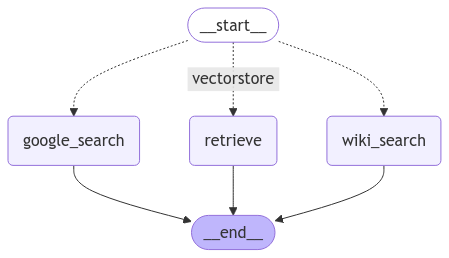

In [10]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [16]:
inputs = {
    "question": "Who is shahrukh khan"
}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Node '{key}':")
       
    pprint("\n---\n")

if isinstance(value, dict) and 'documents' in value:
    documents = value['documents']
    if isinstance(documents, Document):  # If the output is a single Document
        print(documents.page_content)
    elif isinstance(documents, list):  # If the output contains a list of Documents
        for doc in documents:
            print(doc.page_content)

---ROUTE QUESTION---
---ROUTE QUESTION TO Wiki SEARCH---
---wikipedia---
---HELLO--
Who is shahrukh khan
"Node 'wiki_search':"
'\n---\n'
Page: Shahrukh Khan (cricketer)
Summary: Masood Shahrukh Khan (born 27 May 1995) is an Indian cricketer who plays as an Batter for Tamil Nadu in domestic cricket. He is a right-handed batter and an of
